# Sources and inspirations

The exercise is based on "Using data mining to predict secondary school student performance" by P. Cortez and A. Silva (2008).

- https://www.coursera.org/learn/machine-learning/home/week/1
- https://www.coursera.org/learn/machine-learning/home/week/2
- https://www.coursera.org/learn/advanced-learning-algorithms/home/week/4
- https://www.kaggle.com/code/dipam7/introduction-to-eda-and-machine-learning
- https://www.kaggle.com/code/samuelmjoseph/student-grade-prediction-using-decisiontree
- https://lifewithdata.com/2022/03/13/how-to-remove-highly-correlated-features-from-a-dataset/
- https://app.pluralsight.com/player?course=building-regression-models-scikit-learn&author=janani-ravi&name=1616b48f-65fd-4abd-b9fa-7a2560c9d5de&clip=3
- https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1
- https://www.kaggle.com/code/jepsds/feature-selection-using-selectkbest/notebook
- https://scikit-learn.org/stable/modules/tree.html
- https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

# Notation

|General Notation | Description | Python (if applicable) |
|---|---|---|
| $a$ | scalar ||
| $\vec{a}$ | vector ||
| $A$ | matrix ||
| **Multiple variable regression** | | |
| $x$ | "input" variable, feature ||
| $y$ | "output" variable, target ||
|  $X$ | training example matrix | `X_train` |   
|  $\vec{y}$  | training example  targets | `y_train` |
|  $\vec{x}^{(i)}$| features of $ith$ Training example | |
|  $\vec{x}^{(i)}$, $y^{(i)}$ | $i{th}$ Training example | |
| $x_n^{(i)}$ | value of feature n in ith training example ||
| m | number of training examples | `m` |
| n | number of features in each example | `n` |
|  $\vec{w}$  |  parameter: weights | `w` |
| $b$ | parameter: y-intercept | `b` |     
| $f_{\vec{w},b}(\vec{x}^{(i)})$ | the result of the model evaluation at $\vec{x}^{(i)}$ parameterized by $\vec{w},b$: $f_{\vec{w},b}(\vec{x}^{(i)}) = \vec{w} \cdot \vec{x}^{(i)}+b$  | `f_wb` | 
| **Gradient descent** | | |
| $\alpha$ | learning rate ||
| $\frac{\partial J(\vec{w},b)}{\partial w_n}$ | partial derivative term ||
| **Decision tree** | | |
| $H(p_1^\text{node})$ | entropy at the node ||
| $H(p_1^\text{left})$ and $H(p_1^\text{right})$ | the entropies at the left and the right branches resulting from the split ||
| $w^{\text{left}}$ and $w^{\text{right}}$ | the proportion of examples at the left and right branch, respectively ||

# Initial dependencies and data import

You are asked to predict a final grade of the math course based on the information we have about the student. The dataset is provided in the accompanying file `student-mat.csv`. A full description of the data set can be found in the file `metadata.txt`.

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

# Read from csv.
mathscores = pd.read_csv('./data/student-mat.csv', sep=';')

# Data exploration

In [110]:
mathscores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

## G3 distribution

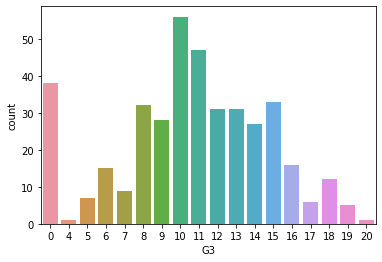

In [111]:
import seaborn as sns

ax = sns.countplot(x="G3", data=mathscores)

# Model 1: Multiple variable linear regression

## Data preparation

`seaborn` is a library that allows a.o. to generate heatmaps. Before calling the library's methods, the correlation matrix of the dataset is computed. In order to perform dimensionality reduction, we want to exclude the variables from the dataset which represent the same information as the one we try to predict. 

The heatmap hereunder shows a very high correlation between G1, G2 and G3 (respectively 0.8 and 0.9). For the purpose at hand, this means that adding G1 and G2 to the dataset would likely increase the predictive power of our model. However, if we are interested in understanding the socio-economic features having a high impact on students' results, we are better off discarding them.

Another approach would be to do feature engineering and compute an average of G1, G2 and G3 and set that as the target.

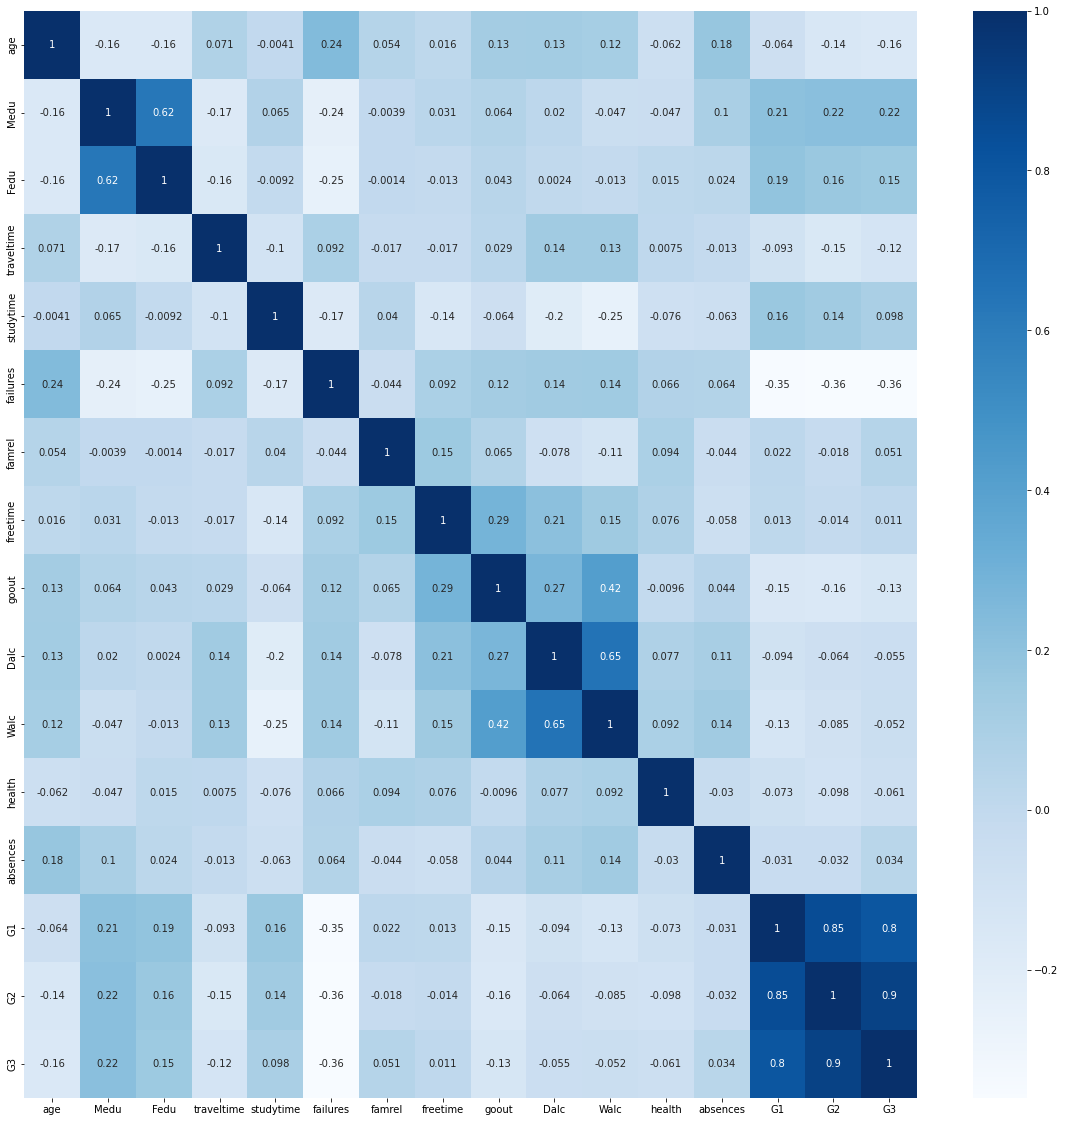

In [112]:
import seaborn as sns

corr_matrix = mathscores.corr()

plt.figure(figsize = (20, 20))
sns.heatmap(corr_matrix, annot = True, cmap="Blues")

# Alternative to heatmap.
# print(mathscores.corr()['G3'].sort_values())
mathscores_without_G1_G2_G3 = mathscores.drop(['G1', 'G2', 'G3'], axis = 'columns')

The next step is to pre-process the dataset before feeding it to the machine learning model. Pre-processing means performing scaling of numeric features and/or encoding of categorical features in order to regularize the data. This increases the efficiency of the machine learning step.

We encode categorical data using one-hot encoding.

In order to tackle the issue of overfitting, the dataset is split into two subsets: `X_train` and `X_test`. The model is trained on the former and the latter is used to perform the actual prediction. The accuracy of the prediction can be measured via standard metrics. Baseline models are also used for comparison.

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# One-hot encoding of categorical features
# categorical_features = mathscores_without_G1_G2_G3.select_dtypes(exclude = ['int64'])
# categorical_features_cols = categorical_features.columns.to_series()
# X = pd.get_dummies(mathscores_without_G1_G2_G3, columns = categorical_features_cols)

mathscores_ohe = pd.get_dummies(mathscores_without_G1_G2_G3, columns = ['Mjob', 'Fjob', 'reason', 'guardian'])

binary_features = mathscores_ohe.select_dtypes(exclude = ['int64', 'uint8'])
binary_features_cols = binary_features.columns.values.tolist()
nominal_features = mathscores_ohe.select_dtypes(include = ['uint8'])
nominal_features_cols = nominal_features.columns.values.tolist()
numeric_features = mathscores_without_G1_G2_G3.select_dtypes(include = ['int64'])
numeric_features_cols = numeric_features.columns.values.tolist()

# Ordinal encoding of binary features. Ordinal encoding is not really meant for this purpose.
ord_enc = OrdinalEncoder(dtype = 'int64')
binary_features = ord_enc.fit_transform(binary_features)

concatenated_cols = binary_features_cols + nominal_features_cols + numeric_features_cols
concatenated = np.concatenate((binary_features, nominal_features, numeric_features), axis = 1)

# Scaling all features.
sc = StandardScaler()
concatenated_scaled = sc.fit_transform(concatenated)

X = pd.DataFrame(concatenated_scaled, columns = concatenated_cols)

# For verification purposes.
# X.to_csv(r'./data/concatenated.csv', index = None, header=True)

y = mathscores['G3']

# 80% - 20% split for the training and testing sets. 316/395 = 0.8 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"X shape: {X_train.shape}, X type:{type(X_train)})")
print(f"y shape: {y_train.shape}, y type:{type(y_train)})")

X shape: (316, 43), X type:<class 'pandas.core.frame.DataFrame'>)
y shape: (316,), y type:<class 'pandas.core.series.Series'>)


In [114]:
# Describe target.
print(mathscores['G3'].describe())

count    395.000000
mean      10.415190
std        4.581443
min        0.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: G3, dtype: float64


## Create and fit the regression model

In mathematical terms, the model function can be expressed as:

$f_{\vec{w},b}(\vec{x}^{(i)}) = \vec{w} . \vec{x} + b$

The values of the $\vec{w}$ vector are called the weights. $b$ is a scalar value and is called the y-intercept. The goal is to find values for these parameters so that $J(\vec{w}, b)$ - the cost function applied to arguments $\vec{w}$, $b$ - is close to zero, meaning that the values cause the algorithm to fit the training set well. Gradient descent is an algorithm that aims to achieve this task as efficiently as possible by repeatedly taking steps in the direction of steepest decrease of $J$.

The algorithm can be formalized as follows:



$$\text{repeat} \text{ until convergence:} \; \lbrace \newline
\;  w_n = w_n -  \alpha \frac{\partial J(\vec{w},b)}{\partial w_n}  \; \newline

b = b -  \alpha \frac{\partial J(\vec{w},b)}{\partial b}  \newline 
\rbrace
$$

where

$$\frac{\partial J(\vec{w},b)}{\partial w_n}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\vec{w},b}(\vec{x}^{(i)}) - y^{(i)})x_n^{(i)} \newline
  \frac{\partial J(\vec{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\vec{w},b}(\vec{x}^{(i)}) - y^{(i)})$$

In [115]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

### Parameters

In [116]:
w = linear_model.coef_
df_w = pd.DataFrame(w, X.columns, columns=['coef']).sort_values(by='coef', ascending=False)

print(df_w)

b = linear_model.intercept_

print(f"b = {b:0.2f}")

                           coef
sex                7.495419e-01
studytime          6.359989e-01
absences           5.306610e-01
Medu               5.090652e-01
higher             3.830018e-01
paid               3.828132e-01
famsize            3.138884e-01
internet           2.704199e-01
famrel             2.650877e-01
freetime           2.463059e-01
school             2.284886e-01
address            1.431990e-01
Walc               5.324347e-02
nursery           -1.226567e-01
Dalc              -1.281941e-01
Fedu              -1.637529e-01
traveltime        -1.822636e-01
Pstatus           -1.972977e-01
health            -2.047206e-01
schoolsup         -3.077032e-01
activities        -3.162381e-01
goout             -4.661128e-01
romantic          -4.786263e-01
age               -4.786438e-01
famsup            -6.155142e-01
failures          -1.377624e+00
Mjob_health       -1.173483e+12
Mjob_teacher      -1.480856e+12
Mjob_at_home      -1.491350e+12
Mjob_services     -1.836935e+12
Mjob_oth

### Make predictions

In [117]:
print(f"Predictions on the training set:\n{linear_model.predict(X_train)[:10]}")
# @ sign computes the dot product of vectors X[i] and w.
print(f"Predictions using w,b:\n{(X_train @ w + b)[:10]}")

y_pred = linear_model.predict(X_test)

df_pred_actual = pd.DataFrame({'predicted': y_pred, 'actual': y_test})

df_pred_actual.head(10)

Predictions on the training set:
[12.10510216 10.69069181  2.19362149  9.02238787 10.14066701  8.289107
  8.5968862   8.13681145 13.74415226 11.71672254]
Predictions using w,b:
181    12.105102
194    10.690692
173     2.193621
63      9.022388
253    10.140667
225     8.289107
331     8.596886
383     8.136811
227    13.744152
342    11.716723
dtype: float64


,predicted,actual
78,1.899646,10
371,7.431637,12
248,8.296846,5
55,11.578240,10
390,10.155930,9
223,9.441253,13
42,13.218056,18
234,12.694375,6
316,10.284281,0
116,12.340050,14


### Metrics

A regressor should present a RMSE close to zero. The `mean_squared_error` - mean squared error (MSE) - of an estimator measures the average of the squares of the errors - that is, the average squared difference between the estimated values and the actual value. Taking the square root of MSE yields the root-mean-square error (RMSE) which has the same units as the quantity being estimated.

The `r2_score` - called the coefficient of determination - is easier to interpret as it can be expressed as a percentage.

In [118]:
from sklearn.metrics import mean_squared_error, r2_score

print("Root mean squared error: %.2f" % mean_squared_error(y_test, y_pred, squared = False))
# 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Root mean squared error: 4.20
Coefficient of determination: 0.14


### Plot predicted vs actuals

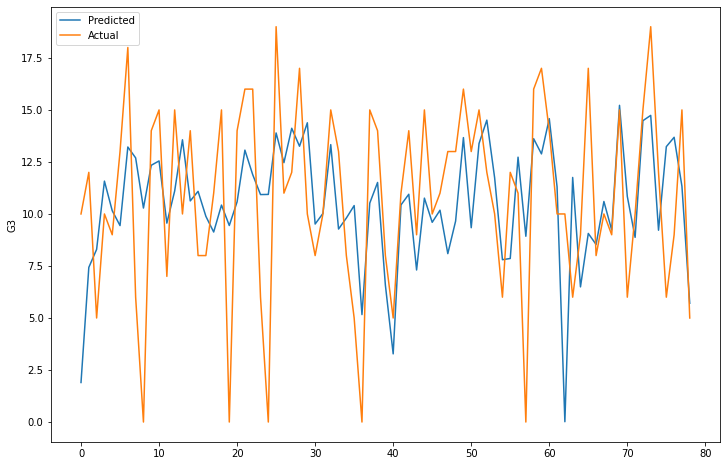

In [119]:
plt.figure(figsize = (12, 8))

plt.plot(y_pred, label='Predicted')
plt.plot(y_test.values, label='Actual')

plt.ylabel('G3')

plt.legend()
plt.show()

### Improving the model

We try to improve the model by selecting the variables which correlate the most with the target. Reducing the number of features can reduce the noise thereby increasing accuracy and performance of the training step. We obtain a model which is slightly more accurate.

In [120]:
concat = pd.concat([X, mathscores['G3']], axis = 1)

most_corr = concat.corr().abs()['G3'].sort_values(ascending = False)
most_corr.drop('G3', inplace = True)
print(most_corr.head(7))

X_temp = pd.DataFrame(concatenated, columns = concatenated_cols)
X = X_temp[['failures', 'Medu', 'higher', 'age', 'Fedu', 'goout', 'romantic']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
m1_y_test = y_test

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)
m1_y_pred = y_pred

print("RMSE: %.2f" % mean_squared_error(y_test, y_pred, squared = False))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

failures    0.360415
Medu        0.217147
higher      0.182465
age         0.161579
Fedu        0.152457
goout       0.132791
romantic    0.129970
Name: G3, dtype: float64
RMSE: 4.22
Coefficient of determination: 0.13


This is another approach to select the most impactful features. However, this does not yield better results than the correlation-based approach.

In [121]:
from sklearn.feature_selection import SelectKBest, chi2

X_new = SelectKBest(chi2, k = 7).fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, random_state = 42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

print("RMSE: %.2f" % mean_squared_error(y_test, y_pred, squared = False))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

RMSE: 4.22
Coefficient of determination: 0.13


# Median baseline

This baseline is used for model 1. For regression models, it is common to create a baseline model that predicts the median of the training dataset. 

In [122]:
median_pred = y_train.median()

# Prediction has constant value.
dummy_pred = [median_pred for _ in range(len(X_test))]

def evaluate_predictions(y_test, dummy_pred):
    rmse = mean_squared_error(y_test, dummy_pred, squared = False)
    r2 = r2_score(y_test, dummy_pred)
    
    return rmse, r2

baseline_rmse, baseline_r2 = evaluate_predictions(y_test, dummy_pred)

print('Median baseline RMSE: {:.4f}'.format(baseline_rmse))
print('Median baseline coefficient of determination: {:.4f}'.format(baseline_r2))

Median baseline RMSE: 4.5340
Median baseline coefficient of determination: -0.0025


# Model 2: Decision trees

As second model, we elected to use a different type of algorithm. Decision tree enable us to discover another kind of machine learning logic.

## Data preparation

Given that decision tree is a classification algorithm, the target variable $y$ needs to be organized as categories. One of the strategies used by the authors of the study was to split up the target in five categories before feeding it to tree-based ML-models. We will use the same approach here.

The categories are:

- A: 16-20
- B: 14-15
- C: 12-13
- D: 10-11
- E: 0-9 

In [123]:
mathscores_without_G1_G2_G3 = mathscores.drop(['G1', 'G2', 'G3'], axis = 'columns')

# Organize targets in a classification system.
def define_label(df):
    classification_list = []
    for score in df:
        if score > 15:
            classification_list.append('A')
        elif score > 13 and score < 16:
            classification_list.append('B')
        elif score > 11 and score < 14:
            classification_list.append('C')
        elif score > 9 and score < 12:
            classification_list.append('D')
        elif score < 10:
            classification_list.append('E')

    return classification_list

y = pd.Series(define_label(mathscores['G3']))

# In order to feed data to DT model, we need to submit categorical features to one-hot encoding.
# From the scikit documentation, we understand that continous features (age, absences) are automatically partitioned into a discrete set of intervals.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
m2_y_test = y_test

print(f"X shape: {X_train.shape}, X type:{type(X_train)})")
print(f"y shape: {y_train.shape}, y type:{type(y_train)})")

X shape: (316, 7), X type:<class 'pandas.core.frame.DataFrame'>)
y shape: (316,), y type:<class 'pandas.core.series.Series'>)


## Create and fit the classification model

The decision tree algorithm functions as follows:

- Of all features, the one with the highest information gain is selected. This feature will serve as the top node. Information gain means the reduction in entropy that you get in the tree from making a given split. Less entropy means greater purity of the node.
- The dataset is split in left and right branches according to the selected feature.
- This process is repeated until the stopping criteria is met.

The stopping criterium can be:
- Stop when a node is 100% one class.
- Stop when splitting a node will result in the tree exceeding a preconfigured max depth.
- Stop when the information gain from additional splits is less than a set threshold.
- Stop when number of examples in a node is below a threshold.

Entropy can be formalized as: 

$$H(p_1) = -p_1 \text{log}_2(p_1) - (1- p_1) \text{log}_2(1- p_1)$$

And the information gain as:

$$\text{Information Gain} = H(p_1^\text{node})- (w^{\text{left}}H(p_1^\text{left}) + w^{\text{right}}H(p_1^\text{right}))$$

In the default scikit-learn implementation, the nodes are expanded until all leaves are pure or until all leaves contain less examples than the `min_samples_split` threshold.

In [124]:
from sklearn import tree

dt_model = tree.DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

### Make predictions

In [125]:
m2_y_pred = dt_model.predict(X_test)

### Metrics

In [126]:
from sklearn.metrics import accuracy_score

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, m2_y_pred)))

Accuracy score: 0.3165


### Improving the model

By tuning the hyperparameters, it is possible to increase the accuracy of the model. 

`max_depth` set the maximum depth of the tree. 

However, tuning this hyperparameter does not result in a higher accuracy score.

In [127]:
dt_model = tree.DecisionTreeClassifier(max_depth = len(X.columns))
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy score: 0.2785


# DummyClassifier baseline

The baseline used against this model is a DummyClassifier which ignores the input features.

In [128]:
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)

dummy_pred = dummy_model.predict(X_test)

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, dummy_pred)))

Accuracy score: 0.3418


# Conclusion

If is difficult to compare model 1 and 2 given the different nature of their respective targets.

While we are not sure about the validity of this method, we decided to reclassify the model 1 predictions according to the model 2 classification. This will allow us to compare the `accuracy_score` of both models. The comparison shows that the accuracy score is almost equal.

In [129]:
m1_y_test_class = define_label(m1_y_test)
m1_y_pred_class = define_label(m1_y_pred)

print('Accuracy score model 1: {:.4f}'.format(accuracy_score(m1_y_test_class, m1_y_pred_class)))
print('Accuracy score model 2: {:.4f}'.format(accuracy_score(m2_y_test, m2_y_pred)))

Accuracy score model 1: 0.2911
Accuracy score model 2: 0.3165
